In [20]:
import pandas as pd
import matplotlib.pyplot as plt 

from pathlib import Path

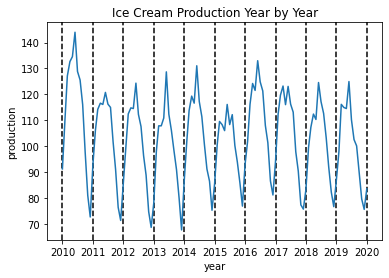

In [26]:
data = pd.read_csv(Path('data') / 'ice_cream.csv')
data.rename(columns={'DATE': 'date', 'IPN31152N': 'production'}, inplace=True)
data.date = pd.to_datetime(data.date)
data.set_index('date', inplace=True)
start_date = pd.to_datetime('2010-01-01')
data = data[start_date:]

plt.title('Ice Cream Production Year by Year')
plt.ylabel('production')
plt.xlabel('year')
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), 
                color='black',
                linestyle='--')
plt.plot(data.production)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

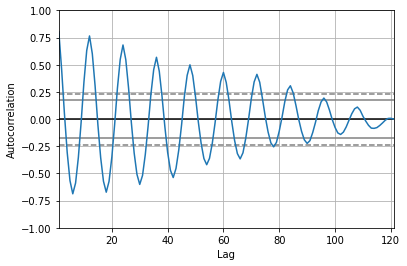

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot


# acf = plot_acf(data.production, lags=120) # 12 months * 10 years = 120 lags
autocorrelation_plot(data.production)

# Based on decaying ACF we're probably dealing with an autoregressive process 

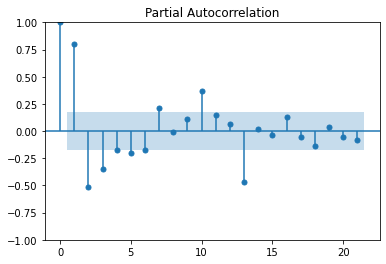

In [28]:
pacf = plot_pacf(data.production, method='ywm')

## Based on PACF we should start with an autoregressive model on lags 1, 2, 3, 10, 13

In [29]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split

# X = data.index.values
# y = data.production.values

train, test = data[:60], data[60:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.1)

/home/oren/Kaggle/time_series_analysis/venv/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/oren/Kaggle/time_series_analysis/venv/lib64/python3.9/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Coefficients: const             7.262655
production.L1     0.908636
production.L2    -0.072950
production.L3    -0.167392
production.L10    0.234318
production.L13    0.018987
dtype: float64


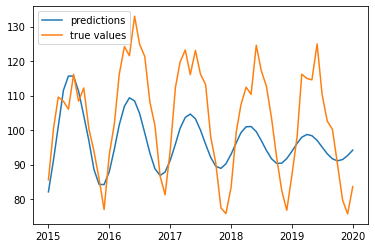

In [30]:
model = AutoReg(train, lags=[1, 2, 3, 10, 13])
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# predictions = model_fit.predict(start=0, end=len(X_train), dynamic=False)
print('Coefficients: %s' % model_fit.params)

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()

# S&P500 

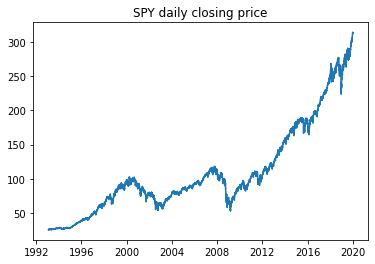

In [34]:
import yfinance 

spy_data = yfinance.Ticker('SPY')
spy_data = spy_data.history(period='1d', start='1950-01-01', end='2020-01-01')
closing_prices = spy_data[['Close']]
plt.title('SPY daily closing price')
plt.plot(closing_prices)
plt.show()

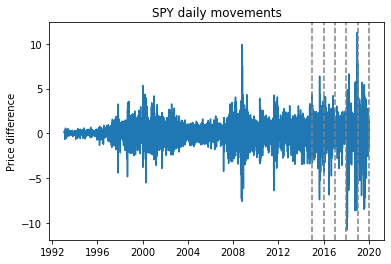

In [35]:
daily_diffs = closing_prices.values[1:] - closing_prices[:-1]
plt.title('SPY daily movements')
plt.ylabel('Price difference')
plt.plot(daily_diffs)
for year in range(2015, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), linestyle='--', color='gray')
plt.show()

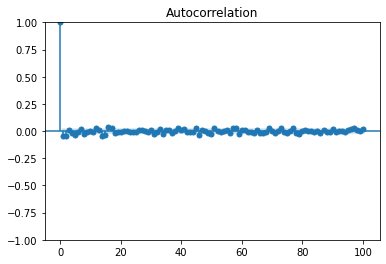

In [43]:
acf_plot = plot_acf(daily_diffs, lags=100)

/home/oren/Kaggle/time_series_analysis/venv/lib64/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


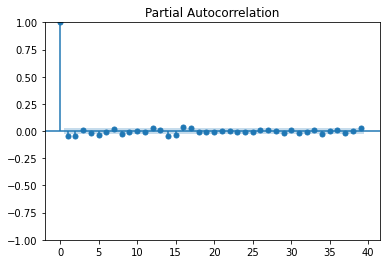

In [37]:
pacf_plot = plot_pacf(daily_diffs)

# no significant autocorrelation (predict stock-market movements is not easy)